In [1]:
import random
import gudhi as gd
import numpy as np
from gudhi.representations import kernel_methods
import networkx as nx
from utils import *

In [6]:
G0 = nx.gnm_random_graph(10,15)
for (u,v) in G0.edges():
    G0.edges[u,v]['time'] = random.randint(0,100)

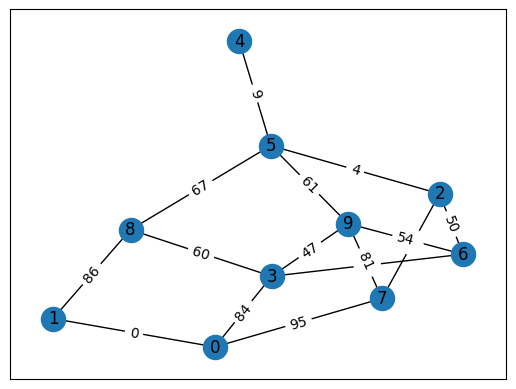

In [7]:
draw_with_labels(G0, 'time')

In [8]:
Ad = adj_fillinf(assign_weights(G0))

usetex mode requires TeX.


<Axes: title={'center': 'Persistence diagram'}, xlabel='Birth', ylabel='Death'>

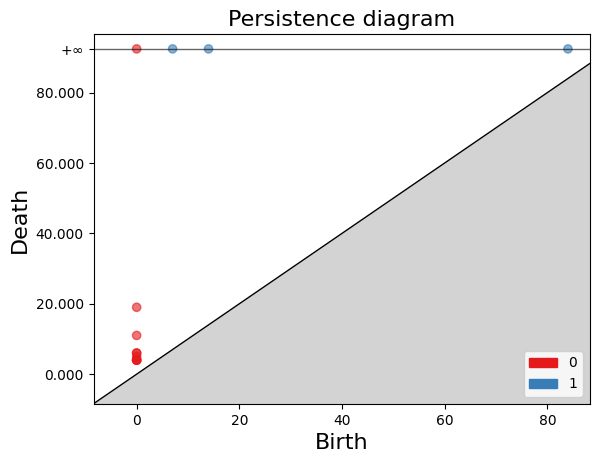

In [9]:
skeleton = gd.RipsComplex(distance_matrix=Ad, max_edge_length=200)
simplex_tree = skeleton.create_simplex_tree(max_dimension=3)
barcode = simplex_tree.persistence()
gd.plot_persistence_diagram(barcode)

In [10]:
np.concatenate((simplex_tree.persistence_intervals_in_dimension(0),
                                               simplex_tree.persistence_intervals_in_dimension(1),
                                               simplex_tree.persistence_intervals_in_dimension(2)), axis=0)

array([[ 0.,  4.],
       [ 0.,  4.],
       [ 0.,  4.],
       [ 0.,  4.],
       [ 0.,  5.],
       [ 0.,  6.],
       [ 0.,  6.],
       [ 0., 11.],
       [ 0., 19.],
       [ 0., inf],
       [ 7., inf],
       [14., inf],
       [84., inf]])

In [2]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

In [3]:
def svm_output(mat_train,mat_test,y_train,y_test):
    # Using SVM

    svm_classifier = SVC(kernel='precomputed')
    svm_classifier.fit(mat_train, y_train)

    # y_pred = svm_classifier.predict(mat_test)

    accuracy = svm_classifier.score(mat_test, y_test)
    print("Accuracy using SVM : ", accuracy)

    # print(classification_report(y_test,y_pred))

def logistic_output(mat_train,mat_test,y_train,y_test):

    # Using logistic regression

    klr = LogisticRegression(max_iter=1000, solver='liblinear')
    klr.kernel = 'precomputed'

    klr.fit(mat_train,y_train)

    # y_pred = klr.predict(mat_test)

    accuracy = klr.score(mat_test, y_test)
    print("Accuracy using Logistic Regression : ", accuracy)

    # print(classification_report(y_test,y_pred))

In [11]:
from tqdm import tqdm

def test_results(v,e,n_cluster,n_copies,wp):
    sparsity = 2 * e / (v * (v + 1))

    class_graphs = [nx.gnm_random_graph(v,e) for _ in range(n_cluster)]
    for G in class_graphs:
        for (u,v) in G.edges():
            G.edges[u,v]['time'] = random.randint(0,100)

    all_graphs = [change_graph(grph,wp) for grph in class_graphs for _ in range(n_copies)]

    label = [i for i in range(n_cluster) for _ in range(n_copies)]

    Lw = []
    for i in all_graphs:
        Lw += [assign_weights(i)]

    Lwe = []
    for i in Lw:
        Lwe += [adj_fillinf(i)]

    # VR = VietorisRipsPersistence(metric="precomputed")
    # diagrams_trial = VR.fit_transform(Lwe)

    input_diag_trial = []

    # Trying Gudhi dimension 0 code
    for Ad in tqdm(Lwe):
        skeleton = gd.RipsComplex(distance_matrix=Ad, max_edge_length=2000)
        simplex_tree = skeleton.create_simplex_tree(max_dimension=3)
        barcode = simplex_tree.persistence()
        # input_diag_trial.append(np.concatenate((simplex_tree.persistence_intervals_in_dimension(0),
        #                                        simplex_tree.persistence_intervals_in_dimension(1),
        #                                        simplex_tree.persistence_intervals_in_dimension(2)), axis=0))
        input_diag_trial.append(simplex_tree.persistence_intervals_in_dimension(2))

    # for diag in diagrams_trial:
    #     input_diag_trial.append(np.delete(diag,-1,axis=1))

    for i in range(n_cluster*n_copies):
        input_diag_trial[i][input_diag_trial[i] == np.inf] = 10000

    X_train, X_test, y_train, y_test = train_test_split(input_diag_trial, label, test_size=0.2, random_state=42)

    X_combined = (X_train + X_test)

    print(f"Sparsity : {sparsity}")

    print("Kernelization starts")

    # Scale Space Kernel

    pssk = kernel_methods.PersistenceScaleSpaceKernel(bandwidth=1)

    # Compute the kernel matrix for the combined data
    pssk_matrix_combined = pssk.fit_transform(X_combined)

    print("Kernelization ends")
    # Normalizing the matrix

    # norm = np.linalg.norm(gram_matrix_combined.flatten())
    # gram_matrix_combined = gram_matrix_combined / norm

    # Split the kernel matrix into train and test parts
    num_train = len(X_train)
    pssk_matrix_train = pssk_matrix_combined[:num_train, :num_train]
    pssk_matrix_test = pssk_matrix_combined[num_train:, :num_train]

    # Weighted Gaussian Kernel

    # pwgk = kernel_methods.PersistenceWeightedGaussianKernel(bandwidth=1)
    # pwgk_matrix_combined = pwgk.fit_transform(X_combined)
    # pwgk_matrix_train = pwgk_matrix_combined[:num_train, :num_train]
    # pwgk_matrix_test = pwgk_matrix_combined[num_train:, :num_train]

    print("Using Scale Space Kernel : ")
    svm_output(pssk_matrix_train,pssk_matrix_test,y_train,y_test)
    logistic_output(pssk_matrix_train,pssk_matrix_test,y_train,y_test)

    # print("Using Weighted Gaussian Kernel : ")
    # svm_output(pwgk_matrix_train,pwgk_matrix_test,y_train,y_test)
    # logistic_output(pwgk_matrix_train,pwgk_matrix_test,y_train,y_test)
    

In [13]:
for i in range(5):
    print(f"\nRun : {i}")
    test_results(50,1000,3,100,0.05)


Run : 0


100%|██████████| 300/300 [00:00<00:00, 596.71it/s]


Sparsity : 0.7843137254901961
Kernelization starts
Kernelization ends
Using Scale Space Kernel : 
Accuracy using SVM :  0.9833333333333333
Accuracy using Logistic Regression :  0.9666666666666667

Run : 1


100%|██████████| 300/300 [00:00<00:00, 580.56it/s]


Sparsity : 0.7843137254901961
Kernelization starts
Kernelization ends
Using Scale Space Kernel : 
Accuracy using SVM :  0.9333333333333333
Accuracy using Logistic Regression :  0.95

Run : 2


100%|██████████| 300/300 [00:00<00:00, 548.04it/s]


Sparsity : 0.7843137254901961
Kernelization starts
Kernelization ends
Using Scale Space Kernel : 
Accuracy using SVM :  0.9666666666666667
Accuracy using Logistic Regression :  0.95

Run : 3


100%|██████████| 300/300 [00:00<00:00, 470.26it/s]


Sparsity : 0.7843137254901961
Kernelization starts
Kernelization ends
Using Scale Space Kernel : 
Accuracy using SVM :  0.9666666666666667
Accuracy using Logistic Regression :  0.95

Run : 4


100%|██████████| 300/300 [00:00<00:00, 517.17it/s]


Sparsity : 0.7843137254901961
Kernelization starts
Kernelization ends
Using Scale Space Kernel : 
Accuracy using SVM :  0.9333333333333333
Accuracy using Logistic Regression :  0.9333333333333333
